In [255]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import stim

False


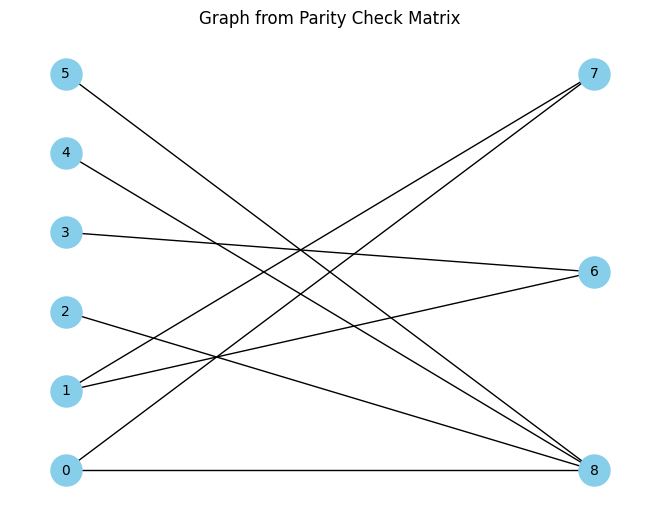

In [347]:
#The following parity check matrix is generated using Radford Neals LDPC-Codes Library
#./make-ldpc dummy 6 12 1 evenboth 3
# Use Reptition Code Parity CHeck Matrix
binary_string = """ 1 0 1 1 0 0 1 0 1 0 0 1
                    0 1 1 0 0 1 1 1 0 0 0 1
                    0 1 0 1 1 1 0 0 1 1 0 0
                    1 1 1 0 1 0 0 0 1 0 1 0
                    0 0 0 0 0 1 1 1 0 1 1 1
                    1 0 0 1 1 0 0 1 0 1 1 0"""

binary_string = """ 0 1 0 1 0 0
                    1 1 0 0 0 0
                    1 0 1 0 1 1 """

small_binary_string = """ 0 1 0 
                    0 1 0 
                    1 0 1  """
H = np.array([[int(bit) for bit in line.split()] for line in binary_string.split('\n')])
print(scipy.sparse.issparse(H))

# Create a bipartite graph
G = nx.Graph()

# Determine the dimensions of the parity check matrix
num_checks, num_vars = H.shape

# Create variable nodes and check nodes
variable_nodes = list(range(num_vars))
check_nodes = list(range(num_vars, num_vars + num_checks))

# Add nodes to the graph
G.add_nodes_from(variable_nodes, bipartite=0)  # Variable nodes
G.add_nodes_from(check_nodes, bipartite=1)     # Check nodes

# Add edges between variable and check nodes based on the parity check matrix
for i in range(num_checks):
    for j in range(num_vars):
        if H[i, j] == 1:
            G.add_edge(j, num_vars + i)


pos = nx.bipartite_layout(G, variable_nodes)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black')
plt.title("Graph from Parity Check Matrix")
plt.show()

1944
1944
3888


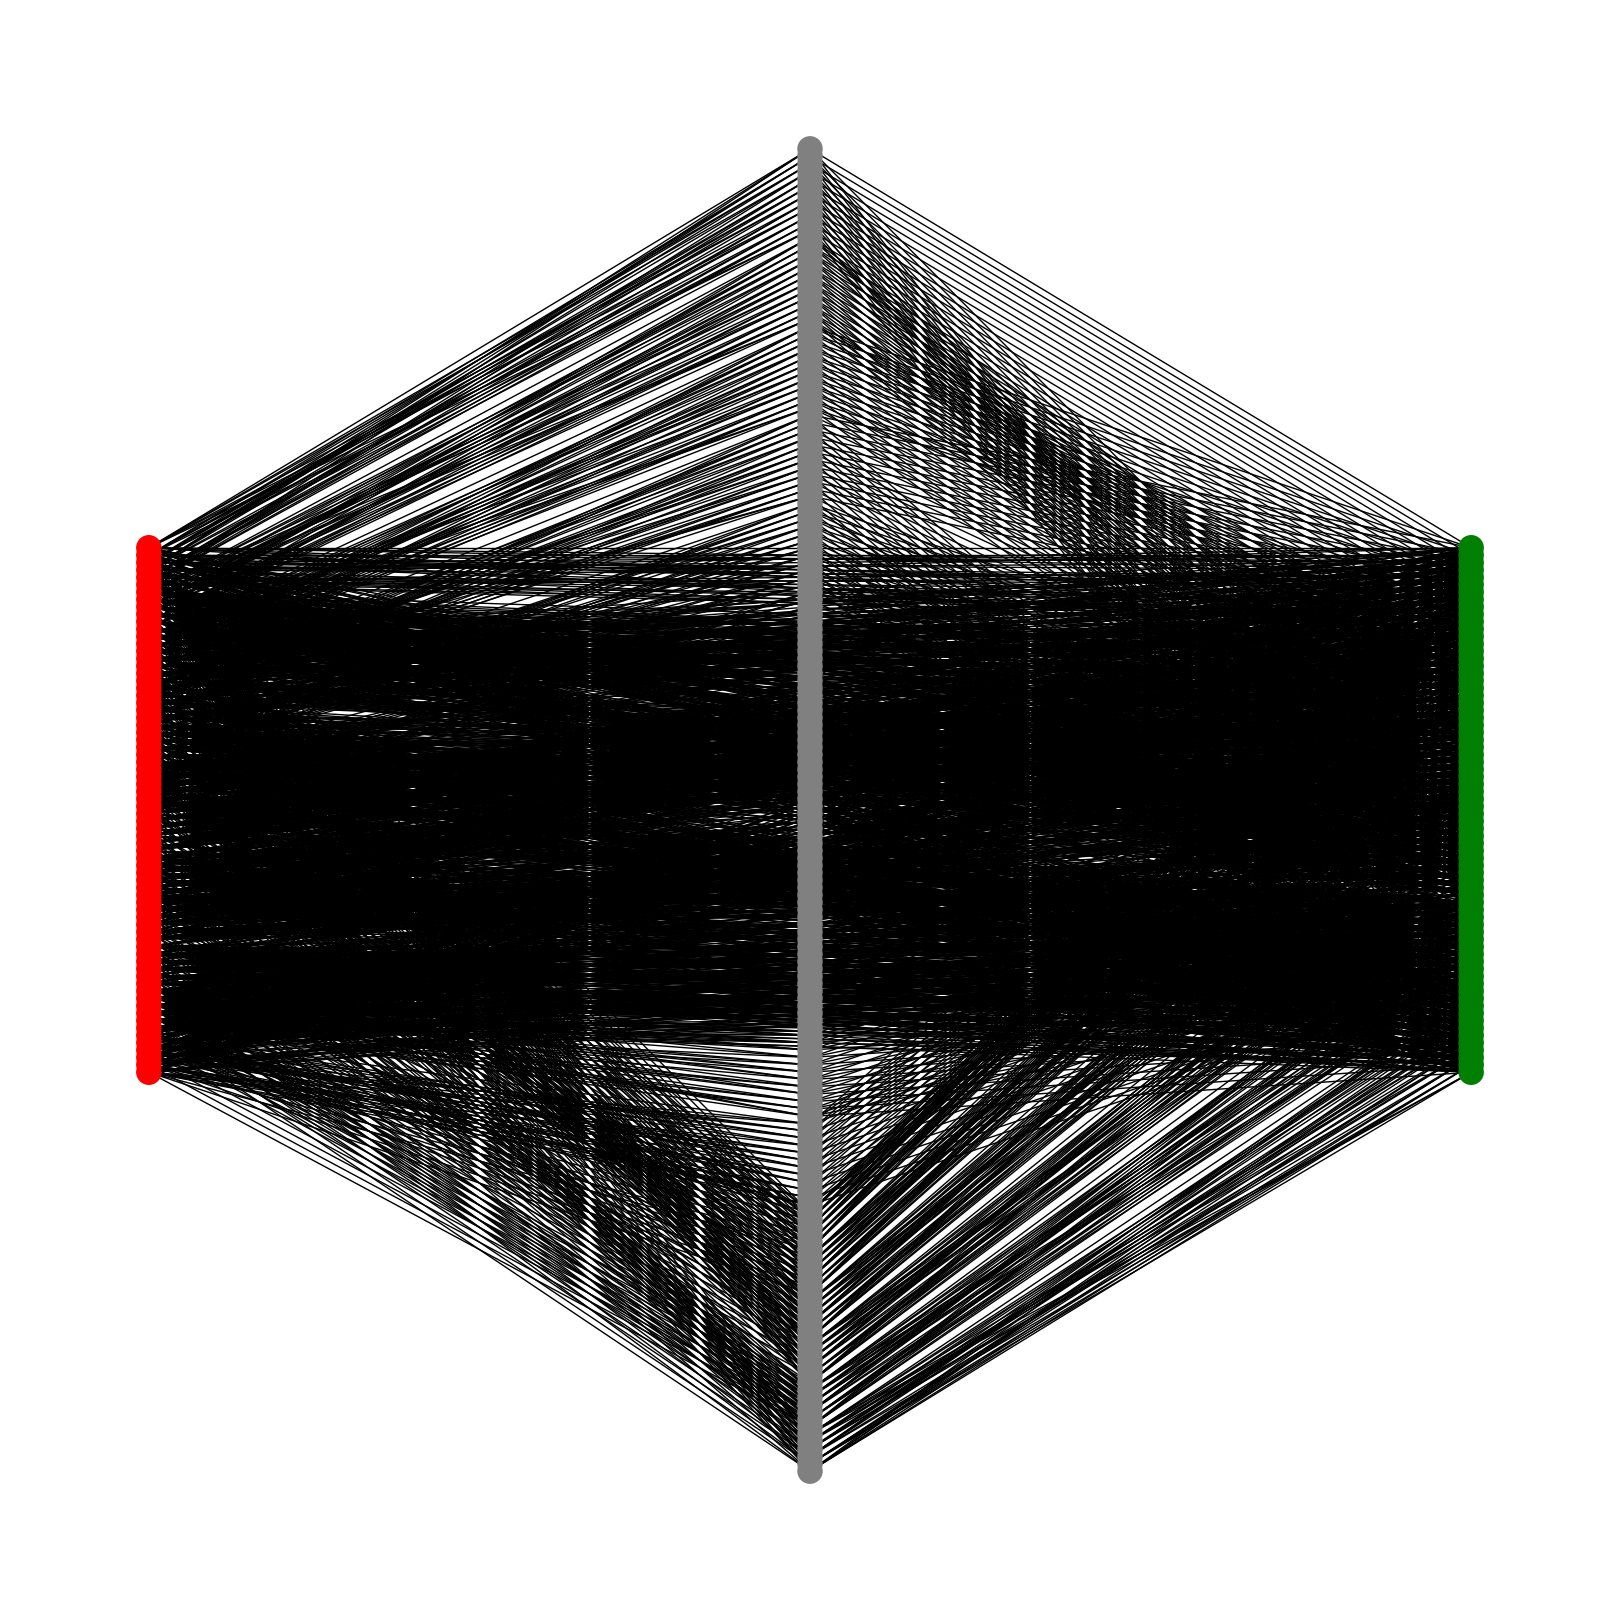

In [344]:
#Code to Construct QLDPC Code From LDPC Code Following Construction given by Tillich and Zemor

#cartesian Product
def cp(a : list[int], b : list[int]):
    res = []
    for i in a:
        for j in b:
            res.append((i,j))
    return res

VxC = cp(variable_nodes,check_nodes)
CxV = cp(check_nodes,variable_nodes) 
VxVuCxC = cp(variable_nodes,variable_nodes) + cp(check_nodes,check_nodes)
Q = nx.strong_product(G,G)
print(len(Q.edges(VxC)))
print(len(Q.edges(CxV)))
print(len(Q.edges))
#Constructing the tripartiteGraph
subset_sizes = [len(VxC) , len(Q.nodes()) - 2*len(VxC), len(CxV)]
subset_color = ["red", "grey", "green"]
HP = nx.Graph()
HP.add_nodes_from(VxC, layer=0)
HP.add_nodes_from(VxVuCxC, layer=1)
HP.add_nodes_from(CxV, layer=2)
HP.add_edges_from(Q.edges)
color = [subset_color[data["layer"]] for v, data in HP.nodes(data=True)]
pos = nx.multipartite_layout(HP, subset_key="layer")
plt.figure(figsize=(16, 16))
nx.draw(HP, pos, node_color=color, with_labels=False)
plt.show()


In [348]:

def run_basic_sim(HP,Qubits,VxC,CxV,VxVuCxC,n,rounds):
    Qubits = {i:list(HP.nodes)[i] for i in range(len(HP.nodes))}
    is_x_check = lambda i : Qubits[i] in VxC
    is_z_check = lambda i : Qubits[i] in CxV
    is_basic = lambda i : Qubits[i] in VxVuCxC
    is_connected = lambda i,j : (Qubits[i],Qubits[j]) in list(HP.edges)
    mcnt=0
    full_circuit = stim.Circuit()
    for i in Qubits:
        if is_basic(i):
            full_circuit.append("M", i)
    circuit = stim.Circuit()
    for i in Qubits:
        if is_basic(i):
            circuit.append("X_ERROR", i, 0.001)
    for i in Qubits:
        if is_basic(i):
            circuit.append("Z_ERROR", i, 0.001)
    for i in Qubits:
        if is_basic(i):
            circuit.append("H", [i])
    for i in Qubits:
        if is_basic(i):
            circuit.append("DEPOLARIZE1", [i],0.001)
    for i in Qubits:
        if is_x_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(i,j):
                    circuit.append("CNOT", [i,j])
    for i in Qubits:
        if is_x_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(i,j):
                    circuit.append("DEPOLARIZE2", [j,i], 0.001)       
    for i in Qubits:
        if is_basic(i):
            circuit.append("H", [i])
    for i in Qubits:
        if is_basic(i):
            circuit.append("DEPOLARIZE1", [i],0.001)
    for i in Qubits:
        if is_z_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(j,i):
                    circuit.append("CNOT", [j,i])
    for i in Qubits:
        if is_z_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(j,i):
                    circuit.append("DEPOLARIZE2", [j,i], 0.01)
    for i in Qubits:
        if is_z_check(i) or is_x_check(i):
            circuit.append_operation("MR",i)  
            mcnt+=1

    full_circuit+=circuit*rounds
    for i in Qubits:
        if is_basic(i):
            full_circuit.append("M", i)
    print(full_circuit)
    m =full_circuit.compile_sampler().sample(n)
    return sum([sum([m[j][0:len(VxVuCxC)][i] != m[j][-len(VxVuCxC):][i] for i in range(len(VxVuCxC))])/len(VxVuCxC) for j in range(n)])/n

In [349]:
run_basic_sim(HP,Qubits,VxC,CxV,VxVuCxC,n=100000,rounds=5)

M 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
REPEAT 5 {
    X_ERROR(0.001) 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 

0.10408566666673372

324
180


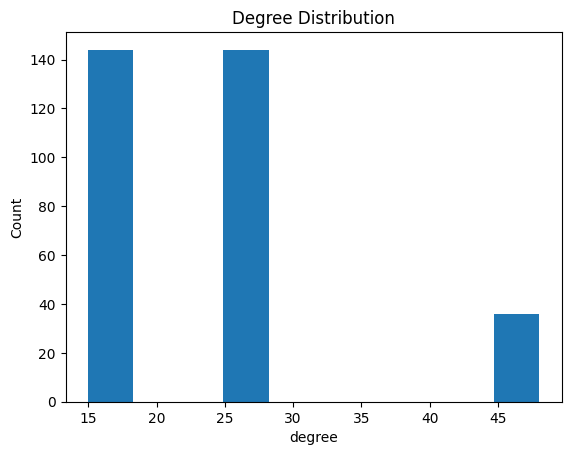

In [350]:
keys = list(HP.nodes)
keys.sort(key= HP.degree)
degrees = list(map(HP.degree, keys))
plt.hist(degrees)
plt.title("Degree Distribution")
plt.xlabel("degree")
plt.ylabel("Count")

print(len(HP.nodes))
print(len(VxVuCxC))

In [ ]:
class NeutralAtom:
    def __init__(self,n,locs):
        self.x = {i:i for i in range(n)}
        self.y = {i:i for i in range(n)}
        self.locs = locs
    def disp(self):
        figure, axes = plt.subplots()
        for x in self.x:
            for y in self.y:
               axes.add_artist(plt.Circle((self.x[x],self.y[y]),0.05, color="red"))
        for loc in self.locs:
            axes.add_artist(plt.Circle(loc, 0.05, color="green"))
        axes.set_aspect( 1 )
        plt.xlim(-1,len(self.x))
        plt.ylim(-1,len(self.x))
        plt.title( 'Colored Circle' )
        figure.set_size_inches(16,16)
        plt.show()
    def move_row(self,row,delta_y):
        self.y[row]+=delta_y
    def move_col(self,col,delta_x):
        self.x[col]+=delta_x

myMachine = NeutralAtom(5,[(0.5,0.5)])
myMachine.disp()
myMachine.move_row(0,0.25)
myMachine.disp()
myMachine.move_col(0,0.25)
myMachine.disp()

In [299]:
min([HP.degree(i) for i in HP.nodes])

3

# Considerations

1. Original Layout

    a. what size grid should be used

    b. Where should the static qubits go

2. Assignment of Qubits to Qubits

    a. What assignment will enable the scheduler to do the best job
    
3. Scheduling

    a. given an assignment how should scheduling happen to minimize circuit depth